In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib import cm
import numpy as np

plot_size_in_inches = (8.3 * 0.9, 8.3 * 0.4)

def axs_defaults(axs):
    axs.title.set_weight('bold')
    axs.xaxis.label.set_style('italic')
    axs.yaxis.label.set_style('italic')
    axs.xaxis.label.set_size(10)
    axs.yaxis.label.set_size(10)

    axs.yaxis.set_tick_params(size=0)
    axs.xaxis.set_tick_params(size=0)


In [2]:
df = pd.read_csv('keep/testdata.csv')

In [3]:
filter = df['test_category'] == 'read'
original_read_df = df[filter]
separate_filter = original_read_df['function_name'].isin(['read_pandas', 'read_pyarrow_to_pandas'])
read_df = original_read_df.loc[~separate_filter, :]
separate_df = original_read_df.loc[separate_filter, :]

In [4]:
function_names = pd.unique(read_df['function_name'])
print(function_names)

['entire_file_to_df' 'get_amount_participants' 'get_amount_colors_used'
 'get_number_of_rows']


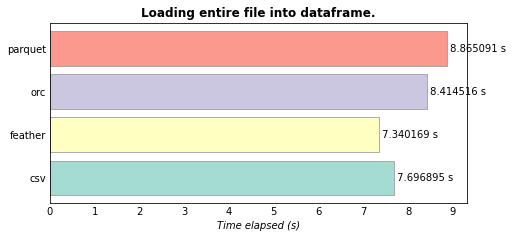

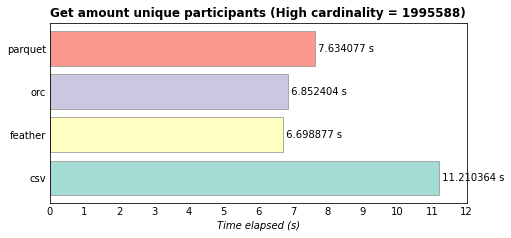

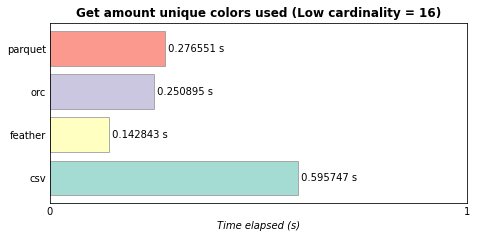

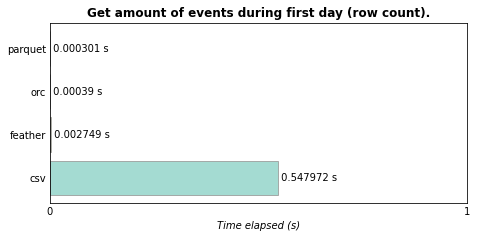

In [5]:
mean_df = (read_df
    .groupby(['function_name', 'filetype'])
    .aggregate({'read_time_in_seconds': 'mean'})
    .reset_index(level=['function_name', 'filetype'])
)

titles = [
    'Loading entire file into dataframe.',
    'Get amount unique participants (High cardinality = 1995588)',
    'Get amount unique colors used (Low cardinality = 16)',
    'Get amount of events during first day (row count).',
]

for i, name in enumerate(function_names):
    fig, axs = plt.subplots(1)
    fig.set_size_inches(*plot_size_in_inches)

    filter = mean_df['function_name'] == name
    function_df = mean_df[filter]
    file_types = function_df['filetype']
    read_times = function_df['read_time_in_seconds']

    axs.set_title(titles[i])
    axs.set_xlabel('Time elapsed (s)')
    axs_defaults(axs)

    y = np.arange(len(file_types))
    bar_colors = [cm.get_cmap('Set3')(i) for i, _ in enumerate(file_types)]
    edge_colors = [cm.get_cmap('Set2')(i) for i, _ in enumerate(file_types)]
    bar = axs.barh(y, read_times, alpha = 0.8, color=bar_colors, edgecolor='#999999')
    labels = [f' {n} s' for n in np.round(read_times, 6)]


    axs.set_yticks(y, file_types)
    x_ticks = np.arange(np.ceil(np.max(read_times)) + 1)
    axs.set_xticks(x_ticks)
    axs.bar_label(bar, labels, label_type='edge')

    fig.savefig(f'graphs-v2/{name}.svg')

In [6]:
sep_mean_df = (separate_df
    .groupby(['function_name', 'filetype'])
    .aggregate({'read_time_in_seconds': 'mean'})
    .reset_index(level=['function_name', 'filetype'])
)
sep_mean_df

,function_name,filetype,read_time_in_seconds
0,read_pandas,csv,17.500954
1,read_pandas,feather,7.719828
2,read_pandas,orc,8.447680
3,read_pandas,parquet,9.145858
4,read_pyarrow_to_pandas,csv,7.735794
5,read_pyarrow_to_pandas,feather,7.306666
6,read_pyarrow_to_pandas,orc,8.402671
7,read_pyarrow_to_pandas,parquet,8.812173


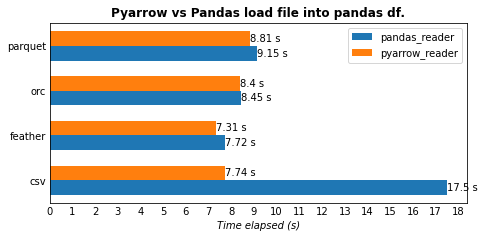

In [7]:
file_types = pd.unique(sep_mean_df['filetype'])
bar_height = 0.33
y = np.arange(len(file_types))
fig, axs = plt.subplots(1)
fig.set_size_inches(*plot_size_in_inches)


pandas_df = sep_mean_df[sep_mean_df['function_name'] == 'read_pandas']
pyarrow_df = sep_mean_df[sep_mean_df['function_name'] == 'read_pyarrow_to_pandas']
pandas_read_times = pandas_df['read_time_in_seconds']
pyarrow_read_times = pyarrow_df['read_time_in_seconds']
pandas_labels = [f'{n} s' for n in np.round(pandas_read_times, 2)]
pyarrow_labels = [f'{n} s' for n in np.round(pyarrow_read_times, 2)]
x_ticks = np.arange(np.ceil(np.max([*pandas_read_times, *pyarrow_read_times])) + 1)

pandas_bar = axs.barh(
    y - bar_height / 2,
    pandas_read_times,
    bar_height,
    label='pandas_reader'
)
pyarrow_bar = axs.barh(
    y + bar_height / 2,
    pyarrow_read_times,
    bar_height,
    label='pyarrow_reader'
)

axs.bar_label(pyarrow_bar, pyarrow_labels)
axs.bar_label(pandas_bar, pandas_labels)


axs.set_xticks(x_ticks)
axs.set_yticks(y, file_types)
axs.legend()
axs.set_title('Pyarrow vs Pandas load file into pandas df.')
axs.set_xlabel('Time elapsed (s)')

axs_defaults(axs)
fig.savefig(f'graphs-v2/pandas_vs_pyarrow.svg')

### Write

In [8]:
write_filter = df['test_category'] == 'write'
original_write_df = df[write_filter]
original_write_df.head()

,test_start,test_category,test_number,function_name,filepath,filetype,write_time_in_seconds,read_time_in_seconds,memory_in_MB,filesize_in_bytes,compression
0,2022-05-14T18:58:45.429824+00:00,write,0,write_file,data/small/day1/2022_place_canvas_history.parquet,parquet,4.846638,-1.0,-1.0,1745220412,NaN
1,2022-05-14T18:58:45.429824+00:00,write,0,write_file,data/small/day1/2022_place_canvas_history.orc,orc,6.364395,-1.0,-1.0,1617754319,NaN
2,2022-05-14T18:58:45.429824+00:00,write,0,write_file,data/small/day1/2022_place_canvas_history.feather,feather,3.773786,-1.0,-1.0,1874427914,NaN
3,2022-05-14T18:58:45.429824+00:00,write,0,write_file,data/small/day1/2022_place_canvas_history.csv,csv,17.022653,-1.0,-1.0,2107617029,NaN
4,2022-05-14T18:58:45.429824+00:00,write,1,write_file,data/small/day1/2022_place_canvas_history.parquet,parquet,3.932717,-1.0,-1.0,1745220412,NaN


In [9]:
write_mean_df = (original_write_df
    .groupby(['function_name', 'filetype'])
    .aggregate({'write_time_in_seconds': 'mean', 'filesize_in_bytes': 'mean'})
    .reset_index(level=['function_name', 'filetype'])
)
write_mean_df.head()

,function_name,filetype,write_time_in_seconds,filesize_in_bytes
0,write_file,csv,16.905631,2.107617e+09
1,write_file,feather,3.211029,1.874428e+09
2,write_file,orc,5.503382,1.617754e+09
3,write_file,parquet,4.061937,1.745220e+09


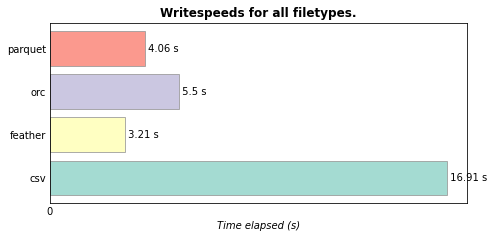

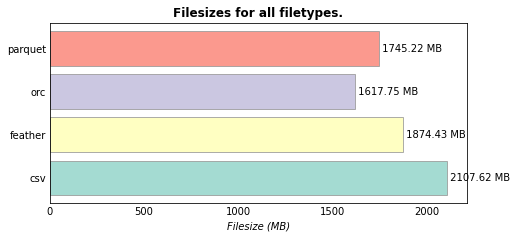

In [10]:
titles = ['Writespeeds for all filetypes.', 'Filesizes for all filetypes.']
x_labels = ['Time elapsed (s)', 'Filesize (MB)']
measures = ['write_time_in_seconds', 'filesize_in_bytes']
suffixes = ['s', 'MB']
for i, measure in enumerate(measures):
    fig, axs = plt.subplots(1)
    fig.set_size_inches(*plot_size_in_inches)

    file_types = write_mean_df['filetype']
    values = write_mean_df[measure]

    if measure == 'filesize_in_bytes':
        values = values / (10 ** 6)

    x_ticks = np.arange(0, np.ceil(np.max(values)) + 1, 500)


    y = np.arange(len(file_types))
    bar_colors = [cm.get_cmap('Set3')(i) for i, _ in enumerate(file_types)]
    bar = axs.barh(y, values, alpha = 0.8, color=bar_colors, edgecolor='#999999')
    labels = [f' {n} {suffixes[i]}' for n in np.round(values, 2)]

    axs.set_yticks(y, file_types)
    axs.set_xticks(x_ticks)
    axs.bar_label(bar, labels, label_type='edge')
    axs.set_title(titles[i])
    axs.set_xlabel(x_labels[i])
    axs_defaults(axs)
    fig.savefig(f'graphs-v2/{titles[i]}.svg')

### Memory

In [11]:
memory_df = df[df['test_category'] == 'memory']
mean_memory_df = (
    memory_df
    .groupby(['function_name', 'filetype'])
    .aggregate({'memory_in_MB': 'mean'})
    .reset_index(level=['function_name', 'filetype'])
)
memory_df.shape

(400, 11)

In [12]:
memory_df

,test_start,test_category,test_number,function_name,filepath,filetype,write_time_in_seconds,read_time_in_seconds,memory_in_MB,filesize_in_bytes,compression
280,2022-05-14T19:27:23.669738+00:00,memory,0,read_table,data/small/day1/2022_place_canvas_history.parquet,parquet,-1.0,-1.0,3732.796875,-1,NaN
281,2022-05-14T19:27:23.669738+00:00,memory,0,read_table,data/small/day1/2022_place_canvas_history.orc,orc,-1.0,-1.0,1868.710938,-1,NaN
282,2022-05-14T19:27:23.669738+00:00,memory,0,read_table,data/small/day1/2022_place_canvas_history.feather,feather,-1.0,-1.0,8.011719,-1,NaN
283,2022-05-14T19:27:23.669738+00:00,memory,0,read_table,data/small/day1/2022_place_canvas_history.csv,csv,-1.0,-1.0,4020.675781,-1,NaN
284,2022-05-14T19:27:23.669738+00:00,memory,1,read_table,data/small/day1/2022_place_canvas_history.parquet,parquet,-1.0,-1.0,4402.164062,-1,NaN
...,...,...,...,...,...,...,...,...,...,...,...
675,2022-05-14T19:27:23.669738+00:00,memory,98,read_table,data/small/day1/2022_place_canvas_history.csv,csv,-1.0,-1.0,4017.847656,-1,NaN
676,2022-05-14T19:27:23.669738+00:00,memory,99,read_table,data/small/day1/2022_place_canvas_history.parquet,parquet,-1.0,-1.0,3695.199219,-1,NaN
677,2022-05-14T19:27:23.669738+00:00,memory,99,read_table,data/small/day1/2022_place_canvas_history.orc,orc,-1.0,-1.0,1857.925781,-1,NaN
678,2022-05-14T19:27:23.669738+00:00,memory,99,read_table,data/small/day1/2022_place_canvas_history.feather,feather,-1.0,-1.0,11.492188,-1,NaN


In [13]:
mean_memory_df.head()

,function_name,filetype,memory_in_MB
0,read_table,csv,4020.346406
1,read_table,feather,9.882969
2,read_table,orc,1868.951992
3,read_table,parquet,3932.044063


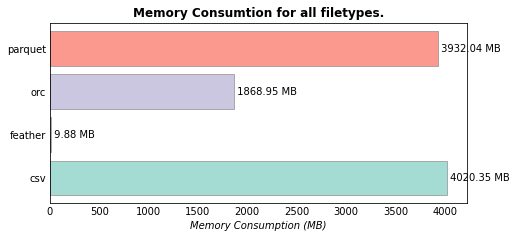

In [14]:
fig, axs = plt.subplots(1)
fig.set_size_inches(*plot_size_in_inches)

filetypes = mean_memory_df['filetype']
memory_in_mb = mean_memory_df['memory_in_MB']

x_ticks = np.arange(0, np.ceil(np.max(memory_in_mb)) + 1, 500)
y = np.arange(len(filetypes))
bar_colors = [cm.get_cmap('Set3')(i) for i, _ in enumerate(filetypes)]
bar = axs.barh(y, memory_in_mb, alpha = 0.8, color=bar_colors, edgecolor='#999999')
labels = [f' {n} MB' for n in np.round(memory_in_mb, 2)]

axs.set_yticks(y, filetypes)
axs.set_xticks(x_ticks)
axs.bar_label(bar, labels, label_type='edge')
axs.set_title('Memory Consumtion for all filetypes.')
axs.set_xlabel('Memory Consumption (MB)')
axs_defaults(axs)
fig.savefig(f'graphs-v2/memory_consumption.svg')

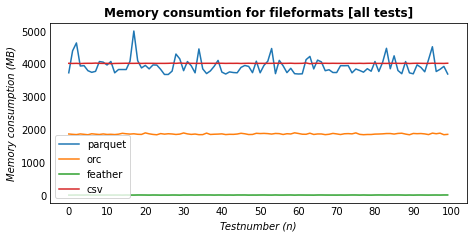

In [15]:
filetypes = pd.unique(memory_df['filetype'])
fig, axs = plt.subplots(1)
axs.set_xticks(range(0, 101, 10))
axs.set_xlabel('Testnumber (n)')
axs.set_ylabel('Memory consumption (MB)')
axs.set_title('Memory consumtion for fileformats [all tests]')
fig.set_size_inches(*plot_size_in_inches)
for filetype in filetypes:
    filetype_filter = memory_df['filetype'] == filetype
    filetype_df = memory_df[filetype_filter]
    memory_mbs = filetype_df['memory_in_MB']
    axs.plot(range(100), memory_mbs, label=filetype)
    axs.legend()

axs_defaults(axs)

fig.savefig('graphs-v2/memory_consumption_all.svg')

## compression

In [16]:
compression_filter = df['test_category'] == 'compression'
compression_df = df[compression_filter].replace({'compression': {'none': 'uncompressed'}})
compression_df.shape

(80, 11)

In [17]:
compression_mean_df = (
    compression_df
    .groupby(['function_name', 'filetype', 'compression'])
    .aggregate({
        'write_time_in_seconds': 'mean', 
        'read_time_in_seconds': 'mean',
        'filesize_in_bytes': 'mean'
    })
    .reset_index(level=['function_name', 'filetype', 'compression'])
)
compression_mean_df


,function_name,filetype,compression,write_time_in_seconds,read_time_in_seconds,filesize_in_bytes
0,"write_and_compress_file, load_data",csv,uncompressed,17.069386,7.807880,2.107617e+09
1,"write_and_compress_file, load_data",csv,zstd,22.328122,8.698758,9.919612e+08
2,"write_and_compress_file, load_data",feather,uncompressed,3.412846,7.434408,1.874428e+09
3,"write_and_compress_file, load_data",feather,zstd,5.305027,8.406541,1.066377e+09
4,"write_and_compress_file, load_data",orc,uncompressed,5.716512,8.512377,1.617754e+09
5,"write_and_compress_file, load_data",orc,zstd,7.212425,9.256799,9.072418e+08
6,"write_and_compress_file, load_data",parquet,uncompressed,4.372531,8.780820,1.745220e+09
7,"write_and_compress_file, load_data",parquet,zstd,7.841425,9.417746,8.994093e+08


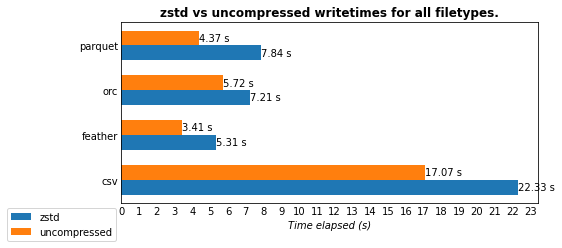

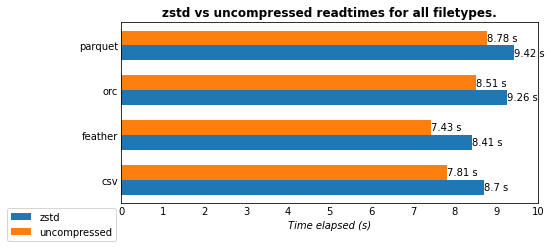

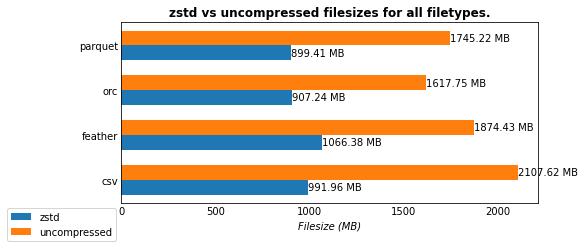

In [18]:
titles = [
    'zstd vs uncompressed writetimes for all filetypes.',
    'zstd vs uncompressed readtimes for all filetypes.',
    'zstd vs uncompressed filesizes for all filetypes.'
]
x_labels = ['Time elapsed (s)', 'Time elapsed (s)', 'Filesize (MB)']
measures = ['write_time_in_seconds', 'read_time_in_seconds', 'filesize_in_bytes']
suffixes = ['s', 's', 'MB']


for i, measure in enumerate(measures):
    fig, axs = plt.subplots(1)
    fig.set_size_inches(*plot_size_in_inches)
    filetypes = pd.unique(compression_mean_df['filetype'])
    bar_height = 0.33
    y = np.arange(len(filetypes))

    zstd_df = compression_mean_df[compression_mean_df['compression'] == 'zstd']
    uncompressed_df = compression_mean_df[compression_mean_df['compression'] == 'uncompressed']

    zstd_values = zstd_df[measure]
    uncompressed_values = uncompressed_df[measure]
    max_value = np.ceil(np.max([*zstd_values, *uncompressed_values])) + 1
    x_ticks = np.arange(0, max_value)

    if measure == 'filesize_in_bytes':
        # Convert values to MB
        zstd_values = zstd_values / (10 ** 6)
        uncompressed_values = uncompressed_values / (10 ** 6)
        max_value = np.ceil(np.max([*zstd_values, *uncompressed_values])) + 1
        x_ticks = np.arange(0, max_value, 500)


    zstd_labels = [f'{n} {suffixes[i]}' for n in np.round(zstd_values, 2)]
    uncompressed_labels = [f'{n} {suffixes[i]}' for n in np.round(uncompressed_values, 2)]

    zstd_bar = axs.barh(
        y - bar_height / 2,
        zstd_values,
        bar_height,
        label='zstd'
    )
    uncompressed_bar = axs.barh(
        y + bar_height / 2,
        uncompressed_values,
        bar_height,
        label='uncompressed'
    )

    axs.bar_label(zstd_bar, zstd_labels)
    axs.bar_label(uncompressed_bar, uncompressed_labels)
    axs.legend(bbox_to_anchor=(0, 0))

    axs.set_yticks(y, filetypes)
    axs.set_xticks(x_ticks)
    axs.set_title(titles[i])
    axs.set_xlabel(x_labels[i])

    axs_defaults(axs)
    fig.savefig(f'graphs-v2/{titles[i]}.svg')